<a href="https://colab.research.google.com/github/pri2k/ML-Practice-Repositories/blob/main/English%20Nagamese%20Language%20Translation/Eng_Ngm_translation_using_OpenNMTtransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

In [ ]:
# get the dataset
with open("/content/eng.txt", 'r', encoding='utf-8') as file:
    eng_txt = file.read()

with open("/content/naga.txt", 'r', encoding='utf-8') as file:
    naga_txt = file.read()

## **Understanding the Dataset**

In [ ]:
# Helper function to read lines from a file
def read_lines(file_path):
    with open(file_path, 'r') as f:
        return [line.strip() for line in f.readlines()]

eng_lines = read_lines("/content/eng.txt")
naga_lines = read_lines("/content/naga.txt")

print(len(eng_lines), len(naga_lines))

7950 7950


In [ ]:
# Analyze sentence lengths
def analyze_lengths(lines):
    lengths = [len(line.split()) for line in lines]
    min_len = min(lengths)
    max_len = max(lengths)
    avg_len = sum(lengths) / len(lengths)
    return lengths, min_len, max_len, avg_len

eng_lengths, eng_min_len, eng_max_len, eng_avg_len = analyze_lengths(eng_lines)
naga_lengths, naga_min_len, naga_max_len, naga_avg_len = analyze_lengths(naga_lines)

print(f"English Sentence Lengths: Min = {eng_min_len}, Max = {eng_max_len}, Avg = {eng_avg_len}")
print(f"Nagamese Sentence Lengths: Min = {naga_min_len}, Max = {naga_max_len}, Avg = {naga_avg_len}")

English Sentence Lengths: Min = 2, Max = 73, Avg = 22.886163522012577
Nagamese Sentence Lengths: Min = 2, Max = 77, Avg = 25.100377358490565


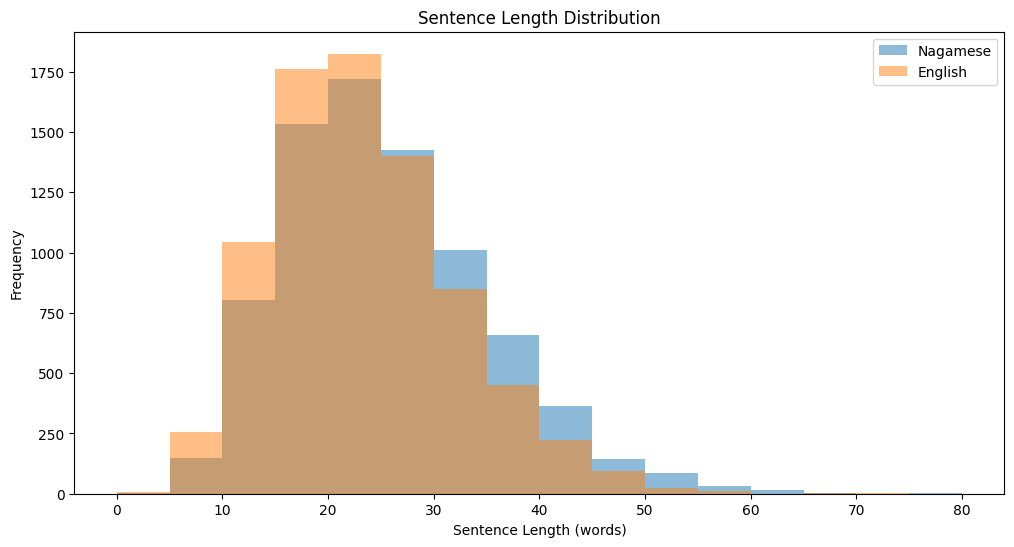

In [ ]:
# Plot sentence length distribution
plt.figure(figsize=(12, 6))
plt.hist(naga_lengths, bins=range(0, max(naga_lengths)+5, 5), alpha=0.5, label='Nagamese')
plt.hist(eng_lengths, bins=range(0, max(eng_lengths)+5, 5), alpha=0.5, label='English')
plt.xlabel('Sentence Length (words)')
plt.ylabel('Frequency')
plt.title('Sentence Length Distribution')
plt.legend()
plt.show()

In [ ]:
def analyze_vocab(lines):
    vocab = Counter(word for line in lines for word in line.split())
    return vocab

eng_vocab_before_processing = analyze_vocab(eng_lines)
naga_vocab_before_processing = analyze_vocab(naga_lines)

print(f"English Vocabulary Size: {len(eng_vocab_before_processing)}")
print(f"Nagamese Vocabulary Size: {len(naga_vocab_before_processing)}")

English Vocabulary Size: 12786
Nagamese Vocabulary Size: 6166


In [ ]:
print("\nMost common words in Source (Nagamese):")
print(eng_vocab_before_processing.most_common(10))
print("\nMost common words in Target (English):")
print(naga_vocab_before_processing.most_common(10))


Most common words in Source (Nagamese):
[('the', 10827), ('and', 6569), ('to', 5921), ('of', 5037), ('you', 2858), ('in', 2831), ('that', 2566), ('is', 2356), ('he', 2123), ('a', 2110)]

Most common words in Target (English):
[('laga', 7705), ('ke', 6596), ('aru', 6348), ('khan', 6343), ('pora', 5431), ('te', 4253), ('tai', 3689), ('itu', 3313), ('kena', 2659), ('Tai', 2619)]


**Sentence Pair Alignment**: It will measure the length differences between source and target sentences.


Sentence Pair Alignment Differences:
Min Difference: 0
Max Difference: 45
Average Difference: 4.11


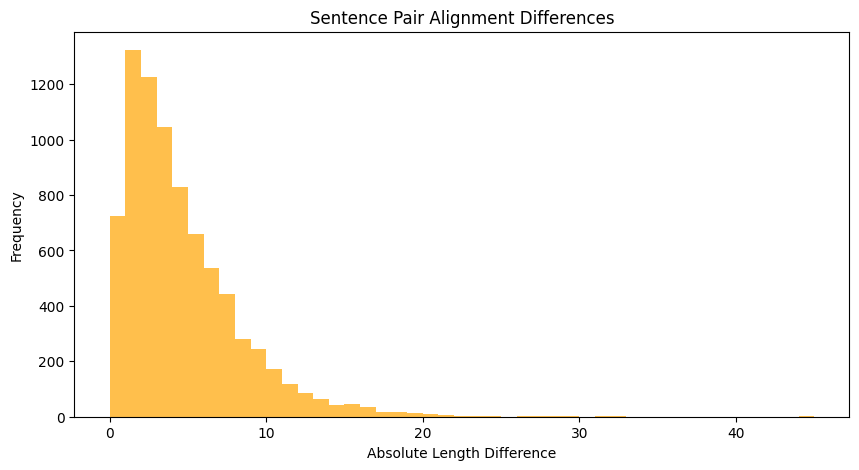

In [ ]:
# Sentence pair alignment analysis
alignment_diffs = [abs(len(src.split()) - len(tgt.split())) for src, tgt in zip(eng_lines, naga_lines)]
print(f"\nSentence Pair Alignment Differences:")
print(f"Min Difference: {min(alignment_diffs)}")
print(f"Max Difference: {max(alignment_diffs)}")
print(f"Average Difference: {sum(alignment_diffs) / len(alignment_diffs):.2f}")

# Plot alignment differences
plt.figure(figsize=(10, 5))
plt.hist(alignment_diffs, bins=range(0, max(alignment_diffs)+1), alpha=0.7, color='orange')
plt.xlabel('Absolute Length Difference')
plt.ylabel('Frequency')
plt.title('Sentence Pair Alignment Differences')
plt.show()

## **Preprocessing the Data**

In [ ]:
import os
import re
import sentencepiece as spm
from collections import Counter

In [ ]:
# Create the enlt directory if not already present
os.makedirs("enlt", exist_ok=True)

# Paths to source and target files
source_file = "naga.txt"
target_file = "eng.txt"
output_dir = "enlt/processed_data"
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# Parameters
max_sentence_length = 80
length_ratio_threshold = 3

In [ ]:
def load_data(file_path):
    """Load sentences from a file."""
    with open(file_path, "r", encoding="utf-8") as f:
        return [line.strip() for line in f.readlines()]

def filter_sentences(source_sentences, target_sentences):
    """Filter sentences based on length and length ratio."""
    filtered_src = []
    filtered_tgt = []
    for src, tgt in zip(source_sentences, target_sentences):
        src_len = len(src.split())
        tgt_len = len(tgt.split())
        if (
            2 <= src_len <= max_sentence_length and
            2 <= tgt_len <= max_sentence_length and
            1 / length_ratio_threshold <= (src_len / tgt_len) <= length_ratio_threshold
        ):
            filtered_src.append(src)
            filtered_tgt.append(tgt)
    return filtered_src, filtered_tgt

def clean_sentence(sentence):
    """Clean sentences by removing unwanted characters or tokens."""
    sentence = re.sub(r"[^a-zA-Z0-9\s]", "", sentence)  # Remove special characters
    sentence = re.sub(r"\s+", " ", sentence).strip()  # Normalize whitespace
    return sentence

def clean_data(sentences):
    """Clean a list of sentences."""
    return [clean_sentence(sentence) for sentence in sentences]

def save_data(sentences, file_path):
    """Save sentences to a file."""
    with open(file_path, "w", encoding="utf-8") as f:
        f.writelines([sentence + "\n" for sentence in sentences])

def train_sentencepiece(input_file, model_prefix, vocab_size):
    """Train a SentencePiece model."""
    spm.SentencePieceTrainer.train(
        input=input_file,
        model_prefix=model_prefix,
        vocab_size=vocab_size,
        character_coverage=1.0,  # Set lower for rare languages if necessary
        model_type="unigram"
    )


In [ ]:
# Load the datasets
print("Loading datasets...")
source_sentences = load_data(source_file)
target_sentences = load_data(target_file)

# Step 1: Clean the data
print("Cleaning datasets...")
source_sentences = clean_data(source_sentences)
target_sentences = clean_data(target_sentences)

# Step 2: Filter sentences
print("Filtering datasets...")
filtered_src, filtered_tgt = filter_sentences(source_sentences, target_sentences)

# Save filtered data
save_data(filtered_src, os.path.join(output_dir, "filtered_naga.txt"))
save_data(filtered_tgt, os.path.join(output_dir, "filtered_eng.txt"))

# Step 3: Train SentencePiece tokenizers
print("Training SentencePiece tokenizers...")
train_sentencepiece(
    os.path.join(output_dir, "filtered_naga.txt"),
    model_prefix=os.path.join(output_dir, "naga_spm"),
    vocab_size=2813  # Adjusted based on vocabulary analysis
)
train_sentencepiece(
    os.path.join(output_dir, "filtered_eng.txt"),
    model_prefix=os.path.join(output_dir, "eng_spm"),
    vocab_size=5182
)


Loading datasets...
Cleaning datasets...
Filtering datasets...
Training SentencePiece tokenizers...


## Model **Training**

In [ ]:
# from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
# import torch

# # Define the models
# naga_to_bengali_model_name = "Helsinki-NLP/opus-mt-mul-bn"  # Multilingual to Bengali
# bengali_to_english_model_name = "Helsinki-NLP/opus-mt-bn-en"  # Bengali to English

# # Load the tokenizers and models
# naga_to_bengali_tokenizer = AutoTokenizer.from_pretrained(naga_to_bengali_model_name)
# naga_to_bengali_model = AutoModelForSeq2SeqLM.from_pretrained(naga_to_bengali_model_name)

# bengali_to_english_tokenizer = AutoTokenizer.from_pretrained(bengali_to_english_model_name)
# bengali_to_english_model = AutoModelForSeq2SeqLM.from_pretrained(bengali_to_english_model_name)

# def translate_text(input_texts, tokenizer, model):
#     translated_texts = []
#     for text in input_texts:
#         inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
#         outputs = model.generate(**inputs)
#         translated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
#         translated_texts.append(translated_text)
#     return translated_texts

# # Load the parallel corpus (Nagamese, Bengali, and English)
# with open('naga.txt', 'r') as f:
#     naga_sentences = f.readlines()

# with open('bangali.txt', 'r') as f:
#     bengali_sentences = f.readlines()

# with open('eng.txt', 'r') as f:
#     english_sentences = f.readlines()

# # Step 1: Nagamese → Bengali
# print("Translating Nagamese to Bengali...")
# bengali_translations = translate_text(naga_sentences, naga_to_bengali_tokenizer, naga_to_bengali_model)
# print("Bengali Translations:", bengali_translations)

# # Step 2: Bengali → English
# print("Translating Bengali to English...")
# english_translations = translate_text(bengali_translations, bengali_to_english_tokenizer, bengali_to_english_model)
# print("English Translations:", english_translations)

# # Now, you have aligned translations for:
# # 1. Nagamese → Bengali
# # 2. Bengali → English


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


OSError: Helsinki-NLP/opus-mt-mul-bn is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

In [ ]:
# Create a directory and clone the Github MT-Preparation repository
!mkdir enlt
%cd enlt
!git clone https://github.com/ymoslem/MT-Preparation.git

# Install the requirements
!pip install -r MT-Preparation/requirements.txt

# Load the dataset
with open("/content/eng.txt", 'r', encoding='utf-8') as file:
    eng_txt = file.read()

with open("/content/naga.txt", 'r', encoding='utf-8') as file:
    naga_txt = file.read()

/content/enlt/enlt
Cloning into 'MT-Preparation'...
remote: Enumerating objects: 305, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 305 (delta 26), reused 21 (delta 20), pack-reused 268 (from 2)
Receiving objects: 100% (305/305), 87.21 KiB | 1.65 MiB/s, done.
Resolving deltas: 100% (147/147), done.


In [ ]:
# Filter the dataset
# Arguments: source file, target file, source language, target language
!python3 MT-Preparation/filtering/filter.py "/content/naga.txt" "/content/eng.txt" ng en

Dataframe shape (rows, columns): (7950, 2)
--- Rows with Empty Cells Deleted	--> Rows: 7950
--- Duplicates Deleted			--> Rows: 7949
--- Source-Copied Rows Deleted		--> Rows: 7949
--- Too Long Source/Target Deleted	--> Rows: 7902
--- HTML Removed			--> Rows: 7902
--- Rows will remain true-cased		--> Rows: 7902
--- Rows with Empty Cells Deleted	--> Rows: 7902
--- Rows Shuffled			--> Rows: 7902
--- Source Saved: /content/naga.txt-filtered.ng
--- Target Saved: /content/eng.txt-filtered.en


In [ ]:
!ls MT-Preparation/subwording/


1-train_bpe.py		  1-train_unigram.py  3-desubword.py
1-train_unigram_joint.py  2-subword.py	      spm_to_vocab.py


In [ ]:
# Train a SentencePiece model for subword tokenization
!python MT-Preparation/subwording/1-train_unigram.py "/content/naga.txt-filtered.ng" "/content/eng.txt-filtered.en"

sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=/content/naga.txt-filtered.ng --model_prefix=source --vocab_size=50000 --hard_vocab_limit=false --split_digits=true
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: /content/naga.txt-filtered.ng
  input_format: 
  model_prefix: source
  model_type: UNIGRAM
  vocab_size: 50000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 1
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 0
  u

In [ ]:
!ls

MT-Preparation	source.model  source.vocab  target.model  target.vocab


In [ ]:
# Subword the dataset
!python3 MT-Preparation/subwording/2-subword.py source.model target.model "/content/naga.txt-filtered.ng" "/content/eng.txt-filtered.en"

Source Model: source.model
Target Model: target.model
Source Dataset: /content/naga.txt-filtered.ng
Target Dataset: /content/eng.txt-filtered.en
Done subwording the source file! Output: /content/naga.txt-filtered.ng.subword
Done subwording the target file! Output: /content/eng.txt-filtered.en.subword


In [ ]:
# First 3 lines before subwording
!head -n 3 "/content/naga.txt-filtered.ng" && echo "-----" && head -n 3 "/content/eng.txt-filtered.en"

Itu hosa ase utu jibon nathaka bajana khan juntu awaj khan ulai basuri hoilebi taar laga bajana hoilebi, jodi taikhan alag-alag awaj khan nadiye koile, kineka pora itu khan ke janibo, basuri pora ki bajai ase aru taar laga bajana pora ki bajai ase?
itu karone manukhan rumal nohoile kapra loikena tai gaw ke chui dibo, aru bemar bhal hoi thake, aru biya atma khan bi gaw chari kena bahar ulai jai thakise.
Tai khan Isor laga asurit kaam to dikhise. Kintu jitia manu khan ki hoise itu dikhise tai khan asurit lagise, Jisu tai laga chela khan ke koise,
-----
In the same way, when lifeless instruments are producing sounds—like the flute or the harp—if they do not produce different tones, how will anyone know what tune the flute or harp is playing?
so that even handkerchiefs and aprons that had touched him were taken to the sick and their illnesses left them and the evil spirits came out of them.
Then they were all amazed at the greatness of God. While they all were marveling at everything he wa

In [ ]:
# First 3 lines after subwording
!head -n 3 "/content/naga.txt-filtered.ng.subword" && echo "---" && head -n 3 "/content/eng.txt-filtered.en.subword"

▁Itu ▁hos a ▁ase ▁ utu ▁jibon ▁nathaka ▁baja na ▁khan ▁juntu ▁awaj ▁khan ▁ulai ▁b asuri ▁hoilebi ▁ta ar ▁laga ▁baja na ▁hoilebi , ▁jodi ▁taikhan ▁alag - alag ▁awaj ▁khan ▁nadiye ▁koile , ▁kineka ▁pora ▁itu ▁khan ▁ke ▁janibo , ▁b asuri ▁pora ▁ki ▁bajai ▁ase ▁aru ▁ta ar ▁laga ▁baja na ▁pora ▁ki ▁bajai ▁ase ?
▁itu ▁karone ▁manukhan ▁ ru mal ▁nohoile ▁kapra ▁loikena ▁tai ▁gaw ▁ke ▁chui ▁dibo , ▁aru ▁bemar ▁bhal ▁hoi ▁thake , ▁aru ▁bi ya ▁atma ▁khan ▁bi ▁gaw ▁chari ▁kena ▁bahar ▁ulai ▁jai ▁thakise .
▁Tai ▁khan ▁Isor ▁laga ▁ asuri t ▁kaam ▁to ▁dikhise . ▁Kintu ▁jitia ▁manu ▁khan ▁ki ▁hoise ▁itu ▁dikhise ▁tai ▁khan ▁ asuri t ▁lagise , ▁Jisu ▁tai ▁laga ▁chela ▁khan ▁ke ▁koise ,
---
▁In ▁the ▁same ▁way , ▁when ▁life less ▁instrument s ▁are ▁produc ing ▁sounds — like ▁the ▁f lute ▁or ▁the ▁harp — if ▁they ▁do ▁not ▁produce ▁different ▁to nes , ▁how ▁will ▁anyone ▁know ▁what ▁ tune ▁the ▁f lute ▁or ▁harp ▁is ▁playing ?
▁so ▁that ▁even ▁hand ker chief s ▁and ▁a pro ns ▁that ▁had ▁touched ▁him ▁wer

In [ ]:
# Split the dataset into training set, development set, and test set
# Development and test sets should be between 1000 and 5000 segments (here we chose 2000)
!python MT-Preparation/train_dev_split/train_dev_test_split.py 500 500 "/content/naga.txt-filtered.ng.subword" "/content/eng.txt-filtered.en.subword"

# Line count for the subworded train, dev, test datatest
!wc -l /content/*.subword.*


Dataframe shape: (7902, 2)
--- Empty Cells Deleted --> Rows: 7902
--- Wrote Files
Done!
Output files
/content/naga.txt-filtered.ng.subword.train
/content/eng.txt-filtered.en.subword.train
/content/naga.txt-filtered.ng.subword.dev
/content/eng.txt-filtered.en.subword.dev
/content/naga.txt-filtered.ng.subword.test
/content/eng.txt-filtered.en.subword.test
    500 /content/eng.txt-filtered.en.subword.dev
    500 /content/eng.txt-filtered.en.subword.test
   6902 /content/eng.txt-filtered.en.subword.train
    500 /content/naga.txt-filtered.ng.subword.dev
    500 /content/naga.txt-filtered.ng.subword.test
   6902 /content/naga.txt-filtered.ng.subword.train
  15804 total


In [ ]:

# Check the first and last line from each dataset

# -------------------------------------------
# Change this cell to print your name
!echo -e "My name is: FirstName SecondName \n"
# -------------------------------------------

!ls
%cd content
# %cd ..
# %cd ..
# !ls

!echo "---First line---"
!head -n 1 *.{train,dev,test}

!echo -e "\n---Last line---"
!tail -n 1 *.{train,dev,test}

My name is: FirstName SecondName 

bin			    dev    lib64		     opt		run   tools
boot			    etc    libx32		     proc		sbin  usr
content			    home   media		     python-apt		srv   var
cuda-keyring_1.0-1_all.deb  lib    mnt			     python-apt.tar.xz	sys
datalab			    lib32  NGC-DL-CONTAINER-LICENSE  root		tmp
/content
---First line---
==> eng.txt-filtered.en.subword.train <==
▁In ▁the ▁same ▁way , ▁when ▁life less ▁instrument s ▁are ▁produc ing ▁sounds — like ▁the ▁f lute ▁or ▁the ▁harp — if ▁they ▁do ▁not ▁produce ▁different ▁to nes , ▁how ▁will ▁anyone ▁know ▁what ▁ tune ▁the ▁f lute ▁or ▁harp ▁is ▁playing ?

==> naga.txt-filtered.ng.subword.train <==
▁Itu ▁hos a ▁ase ▁ utu ▁jibon ▁nathaka ▁baja na ▁khan ▁juntu ▁awaj ▁khan ▁ulai ▁b asuri ▁hoilebi ▁ta ar ▁laga ▁baja na ▁hoilebi , ▁jodi ▁taikhan ▁alag - alag ▁awaj ▁khan ▁nadiye ▁koile , ▁kineka ▁pora ▁itu ▁khan ▁ke ▁janibo , ▁b asuri ▁pora ▁ki ▁bajai ▁ase ▁aru ▁ta ar ▁laga ▁baja na ▁pora ▁ki ▁bajai ▁ase ?

==> eng.txt-filtered.en.subword.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Move your data to your Google Drive
# %cd ..
!mv /content/enlt /content/drive/MyDrive/ENLT/

mv: cannot stat '/content/enlt': No such file or directory


**training**

In [ ]:
# Install OpenNMT-py 3.x
!pip3 install OpenNMT-py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 262.8/262.8 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 95.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#  Open the folder where you saved your prepapred datasets
%cd "/content/drive/MyDrive/ENLT/enlt"
!ls

/content/drive/MyDrive/ENLT/enlt
eng.txt				     naga.txt-filtered.ng.subword
eng.txt-filtered.en		     naga.txt-filtered.ng.subword.dev
eng.txt-filtered.en.subword	     naga.txt-filtered.ng.subword.test
eng.txt-filtered.en.subword-2.train  naga.txt-filtered.ng.subword.train
eng.txt-filtered.en.subword.dev      source.model
eng.txt-filtered.en.subword.test     source.vocab
MT-Preparation			     target.model
naga.txt			     target.vocab
naga.txt-filtered.ng


In [ ]:
# Create the YAML configuration file
# On a regular machine, you can create it manually or with nano
# Note here we are using some smaller values because the dataset is small
# For larger datasets, consider increasing: train_steps, valid_steps, warmup_steps, save_checkpoint_steps, keep_checkpoint

config = '''# config.yaml


## Where the samples will be written
save_data: run

# Training files
data:
    corpus_1:
        path_src: naga.txt-filtered.ng.subword.train
        path_tgt: eng.txt-filtered.en.subword.train
        transforms: [filtertoolong]
    valid:
        path_src: naga.txt-filtered.ng.subword.dev
        path_tgt: eng.txt-filtered.en.subword.dev
        transforms: [filtertoolong]

# Vocabulary files, generated by onmt_build_vocab
src_vocab: run/source.vocab
tgt_vocab: run/target.vocab

# Vocabulary size - should be the same as in sentence piece
src_vocab_size: 50000
tgt_vocab_size: 50000

# Filter out source/target longer than n if [filtertoolong] enabled
src_seq_length: 150
src_seq_length: 150

# Tokenization options
src_subword_model: source.model
tgt_subword_model: target.model

# Where to save the log file and the output models/checkpoints
log_file: train.log
save_model: models/model.fren

# Stop training if it does not imporve after n validations
early_stopping: 4

# Default: 5000 - Save a model checkpoint for each n
save_checkpoint_steps: 1000

# To save space, limit checkpoints to last n
# keep_checkpoint: 3

seed: 3435

# Default: 100000 - Train the model to max n steps
# Increase to 200000 or more for large datasets
# For fine-tuning, add up the required steps to the original steps
train_steps: 3000

# Default: 10000 - Run validation after n steps
valid_steps: 1000

# Default: 4000 - for large datasets, try up to 8000
warmup_steps: 1000
report_every: 100

# Number of GPUs, and IDs of GPUs
world_size: 1
gpu_ranks: [0]

# Batching
bucket_size: 262144
num_workers: 0  # Default: 2, set to 0 when RAM out of memory
batch_type: "tokens"
batch_size: 4096   # Tokens per batch, change when CUDA out of memory
valid_batch_size: 2048
max_generator_batches: 2
accum_count: [4]
accum_steps: [0]

# Optimization
model_dtype: "fp16"
optim: "adam"
learning_rate: 2
# warmup_steps: 8000
decay_method: "noam"
adam_beta2: 0.998
max_grad_norm: 0
label_smoothing: 0.1
param_init: 0
param_init_glorot: true
normalization: "tokens"

# Model
encoder_type: transformer
decoder_type: transformer
position_encoding: true
enc_layers: 6
dec_layers: 6
heads: 8
hidden_size: 512
word_vec_size: 512
transformer_ff: 2048
dropout_steps: [0]
dropout: [0.1]
attention_dropout: [0.1]
'''

with open("config.yaml", "w+") as config_yaml:
  config_yaml.write(config)

In [ ]:
# [Optional] Check the content of the configuration file
!cat config.yaml

# config.yaml


## Where the samples will be written
save_data: run

# Training files
data:
    corpus_1:
        path_src: naga.txt-filtered.ng.subword.train
        path_tgt: eng.txt-filtered.en.subword.train
        transforms: [filtertoolong]
    valid:
        path_src: naga.txt-filtered.ng.subword.dev
        path_tgt: eng.txt-filtered.en.subword.dev
        transforms: [filtertoolong]

# Vocabulary files, generated by onmt_build_vocab
src_vocab: run/source.vocab
tgt_vocab: run/target.vocab

# Vocabulary size - should be the same as in sentence piece
src_vocab_size: 50000
tgt_vocab_size: 50000

# Filter out source/target longer than n if [filtertoolong] enabled
src_seq_length: 150
src_seq_length: 150

# Tokenization options
src_subword_model: source.model
tgt_subword_model: target.model

# Where to save the log file and the output models/checkpoints
log_file: train.log
save_model: models/model.fren

# Stop training if it does not imporve after n validations
early_stopping: 4

# D

In [ ]:
# Find the number of CPUs/cores on the machine
!nproc --all

2


In [ ]:
# Build Vocabulary

# -config: path to your config.yaml file
# -n_sample: use -1 to build vocabulary on all the segment in the training dataset
# -num_threads: change it to match the number of CPUs to run it faster
!ls
!onmt_build_vocab -config config.yaml -n_sample -1 -num_threads 2

config.yaml			   naga.txt-filtered.ng
eng.txt				   naga.txt-filtered.ng.subword
eng.txt-filtered.en		   naga.txt-filtered.ng.subword.dev
eng.txt-filtered.en.subword	   naga.txt-filtered.ng.subword.test
eng.txt-filtered.en.subword.dev    naga.txt-filtered.ng.subword.train
eng.txt-filtered.en.subword.test   source.model
eng.txt-filtered.en.subword.train  source.vocab
MT-Preparation			   target.model
naga.txt			   target.vocab
Corpus corpus_1's weight should be given. We default it to 1 for you.
[2025-01-12 11:09:22,547 INFO] Counter vocab from -1 samples.
[2025-01-12 11:09:22,547 INFO] n_sample=-1: Build vocab on full datasets.
[2025-01-12 11:09:24,677 INFO] Counters src: 2851
[2025-01-12 11:09:24,678 INFO] Counters tgt: 5325


In [ ]:
# Check if the GPU is active
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-93c684eb-773b-f099-de94-ebcc217ac4a0)


In [ ]:
# Check if the GPU is visible to PyTorch

import torch

print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

gpu_memory = torch.cuda.mem_get_info(0)
print("Free GPU memory:", gpu_memory[0]/1024**2, "out of:", gpu_memory[1]/1024**2)

True
Tesla T4
Free GPU memory: 14999.0625 out of: 15102.0625


In [ ]:
!rm -rf drive/MyDrive/ENLT/enlt/models/

In [ ]:
# Train the NMT model
!onmt_train -config config.yaml

Streaming output truncated to the last 5000 lines.
			* corpus_1: 2215
[2025-01-12 11:59:51,042 INFO] Weighted corpora loaded so far:
			* corpus_1: 2216
[2025-01-12 11:59:55,827 INFO] Weighted corpora loaded so far:
			* corpus_1: 2217
[2025-01-12 11:59:56,105 INFO] Weighted corpora loaded so far:
			* corpus_1: 2218
[2025-01-12 11:59:56,388 INFO] Weighted corpora loaded so far:
			* corpus_1: 2219
[2025-01-12 11:59:56,669 INFO] Weighted corpora loaded so far:
			* corpus_1: 2220
[2025-01-12 11:59:56,953 INFO] Weighted corpora loaded so far:
			* corpus_1: 2221
[2025-01-12 11:59:57,241 INFO] Weighted corpora loaded so far:
			* corpus_1: 2222
[2025-01-12 11:59:57,529 INFO] Weighted corpora loaded so far:
			* corpus_1: 2223
[2025-01-12 11:59:57,816 INFO] Weighted corpora loaded so far:
			* corpus_1: 2224
[2025-01-12 11:59:58,086 INFO] Weighted corpora loaded so far:
			* corpus_1: 2225
[2025-01-12 11:59:58,362 INFO] Weighted corpora loaded so far:
			* corpus_1: 2226
[2025-01-12 11:5